In [3]:
import sys
sys.path.append('/content/drive/My Drive/colab')
signal_filepath = "/content/drive/My Drive/colab/LLFFNN_VertexImages_Signal_277Sig.csv"
background_filepath = "/content/drive/My Drive/colab/LLFFNN_VertexImages_Background_277Sig.csv"
lumi_filepath = "/content/drive/My Drive/colab/Luminosity data.csv"

In [4]:
from keras.regularizers import l2
try:
  import uproot
except ImportError:
  !pip install uproot
try:
  import uproot3
except ImportError:
  !pip install uproot3
try:
  import uncertainties
except ImportError:
  !pip install uncertainties
import LLFFNN_Utils
import time
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc

In [5]:
#Hyperparameters
desired_variables = ['CNN Predictions', 'Filename', 'vtx_err_dBV', 'vtx_ntrack', 'vtx_yerr', 'vtx_pv3derr', 'vtx_xerr', 'vtx_zerr', 'vtx_pt_sum',
                     'vtx_E', 'vtx_dBV', 'vtx_pv3d', 'vtx_pt_vec', 'vtx_pz', 'vtx_y', 'vtx_chi2dof', 'vtx_px',
											'vtx_py', 'vtx_x', 'vtx_pv3dsig', 'vtx_z']
run = 8
save_model = False
load_model = True
if save_model == True and load_model == True:
  print("ERROR: Both 'save_model' and 'load_model' should not be True. Change one of them.")
  sys.exit()
checkpoint_filepath = "/content/drive/My Drive/colab/Model Checkpoints/LLFFNN_VertexImages_Run{}".format(run)
min_bkg = 1
testing_fraction = 0.3
batch_size = 1024
dropout = 0.3
epochs = 250
patience = 50
min_delta = 0.01
input_layer_nodes = 400
hidden_layer1_nodes = 20
l2_reg = l2(0.0125)
np.random.seed(7)

In [6]:
dfsignal = pd.read_csv(signal_filepath)
dfbackground = pd.read_csv(background_filepath)

#Reduce the dataframe to only the desired variables
dfsignal = LLFFNN_Utils.getvars(dfsignal, desired_variables)
dfbackground = LLFFNN_Utils.getvars(dfbackground, desired_variables)

#Change variable range
#dfsignal = LLFFNN_Utils.manipulate_var_ranges(dfsignal, range1=5, range2=5)
#dfbackground = LLFFNN_Utils.manipulate_var_ranges(dfbackground, range1=5, range2=5)

vars = []
for var in dfsignal:
    vars.append(var)
varlen = len(vars)

#Preprocess the data
data_test, data_train, data_val, label_test, label_train, label_val, sig_nEvents, bkg_nEvents = LLFFNN_Utils.process(dfsignal, dfbackground, vars, testing_fraction, equal_bkg_sig_samples=True)
if 'Filename' in data_train.keys():
  varlen = len(vars)
  train_filenames = data_train['Filename']
  test_filenames = data_test['Filename']
  val_filenames = data_val['Filename']
  data_train.drop(axis=1, columns='Filename', inplace=True)
  data_test.drop(axis=1, columns='Filename', inplace=True)
  data_val.drop(axis=1, columns='Filename', inplace=True)

Reducing the dataframe to the following variables:
['CNN Predictions', 'Filename', 'vtx_err_dBV', 'vtx_ntrack', 'vtx_yerr', 'vtx_pv3derr', 'vtx_xerr', 'vtx_zerr', 'vtx_pt_sum', 'vtx_E', 'vtx_dBV', 'vtx_pv3d', 'vtx_pt_vec', 'vtx_pz', 'vtx_y', 'vtx_chi2dof', 'vtx_px', 'vtx_py', 'vtx_x', 'vtx_pv3dsig', 'vtx_z']
Reducing the dataframe to the following variables:
['CNN Predictions', 'Filename', 'vtx_err_dBV', 'vtx_ntrack', 'vtx_yerr', 'vtx_pv3derr', 'vtx_xerr', 'vtx_zerr', 'vtx_pt_sum', 'vtx_E', 'vtx_dBV', 'vtx_pv3d', 'vtx_pt_vec', 'vtx_pz', 'vtx_y', 'vtx_chi2dof', 'vtx_px', 'vtx_py', 'vtx_x', 'vtx_pv3dsig', 'vtx_z']
Background samples reduced to equal signal samples. Background length = 38344, Signal length = 38344


Loading the model from run 8
[0.0125, 0.037500000000000006, 0.0625, 0.08750000000000001, 0.1125, 0.1375, 0.16249999999999998, 0.1875, 0.21249999999999997, 0.2375, 0.26249999999999996, 0.2875, 0.3125, 0.3375, 0.36250000000000004, 0.38750000000000007, 0.4125000000000001, 0.4375000000000001, 0.46250000000000013, 0.48750000000000016, 0.5125000000000002, 0.5375000000000001, 0.5625000000000002, 0.5875000000000001, 0.6125000000000003, 0.6375000000000002, 0.6625000000000003, 0.6875000000000002, 0.7125000000000004, 0.7375000000000003, 0.7625000000000004, 0.7875000000000003, 0.8125000000000004, 0.8375000000000004, 0.8625000000000005, 0.8875000000000004, 0.9125000000000005, 0.9375000000000004, 0.9625000000000006, 0.9875000000000005] [0.001886633, 0.0010555150000000001, 0.000427, 0.000895367, 0.00039920000000000005, 0.000567, 0.00034409999999999996, 0.0005210999999999999, 0.00034270000000000004, 0.0005444, 0.0007418710000000001, 0.00034389999999999996, 0.0003201, 0.0006834710000000001, 0.0003391, 

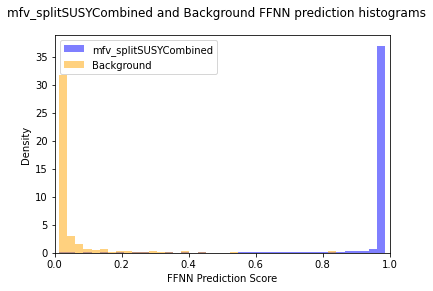

Total signal vertices in histogram: 0.4+/-0.6
Total background vertices in histogram: 384+/-20
signalROOT = mfv_splitSUSYCombined, nSig = 0.345117044, nBkg = 3.361654328999999 with significance = 0.19 +/- 0.31 for FFNN score > 0.841
[0.0125, 0.037500000000000006, 0.0625, 0.08750000000000001, 0.1125, 0.1375, 0.16249999999999998, 0.1875, 0.21249999999999997, 0.2375, 0.26249999999999996, 0.2875, 0.3125, 0.3375, 0.36250000000000004, 0.38750000000000007, 0.4125000000000001, 0.4375000000000001, 0.46250000000000013, 0.48750000000000016, 0.5125000000000002, 0.5375000000000001, 0.5625000000000002, 0.5875000000000001, 0.6125000000000003, 0.6375000000000002, 0.6625000000000003, 0.6875000000000002, 0.7125000000000004, 0.7375000000000003, 0.7625000000000004, 0.7875000000000003, 0.8125000000000004, 0.8375000000000004, 0.8625000000000005, 0.8875000000000004, 0.9125000000000005, 0.9375000000000004, 0.9625000000000006, 0.9875000000000005] [0.0, 3.31e-05, 0.0, 0.0, 0.0, 0.0, 3.31e-05, 6.62e-05, 0.0, 0.0

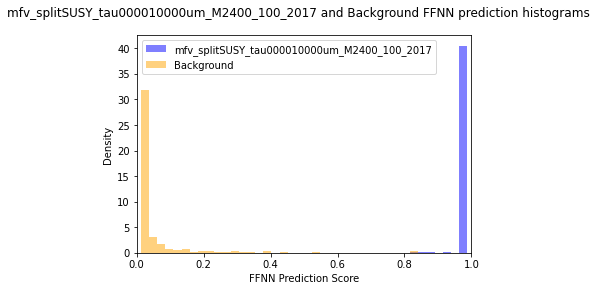

Total signal vertices in histogram: 0.07+/-0.26
Total background vertices in histogram: 384+/-20
signalROOT = mfv_splitSUSY_tau000010000um_M2400_100_2017, nSig = 0.0673254, nBkg = 3.361654328999999 with significance = 0.04 +/- 0.14 for FFNN score > 0.841


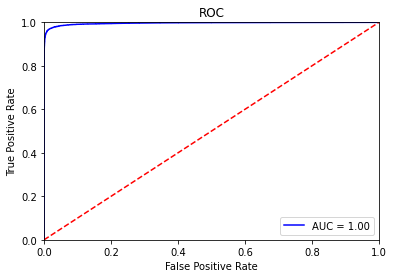

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               8400      
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 batch_normalization (BatchN  (None, 400)              1600      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 20)                8020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 18,041
Trainable params: 17,241
Non-trainable params: 800
__________________________________________________

In [7]:
#Create model
model = Sequential()
model.add(Dense(input_layer_nodes, activation='relu', input_dim=varlen, kernel_regularizer=l2_reg))
model.add(Dropout(dropout))
model.add(BatchNormalization())
model.add(Dense(hidden_layer1_nodes, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

if load_model == False:
  # Setup callbacks
  if save_model:
    fit_callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience, min_delta=min_delta, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', verbose=0, save_best_only=True)]
  else:
    fit_callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience, min_delta=min_delta, restore_best_weights=True)]

  # Train model
  print("Beginning model training")
  start_time = time.time()
  history = model.fit(data_train, label_train, validation_data=(data_val, label_val), epochs=epochs,
                      callbacks=fit_callbacks, verbose=2, batch_size=batch_size)
  model_time = time.time() - start_time
  print("--- Train model time %s seconds ---" % model_time)
else:
  print("Loading the model from run {}".format(run))
  model.load_weights(checkpoint_filepath)

#Analyze model
#trainscores, testscores = LLFFNN_Utils.accuracy(model, data_train, label_train, data_test, label_test)
#print(trainscores, '\n', testscores)
test_filenames = test_filenames.reset_index()
test_filenames = test_filenames['Filename']
LLFFNN_Utils.significance2(model, data_test, label_test, test_filenames, lumi_filepath, 
                           signalROOT=['mfv_splitSUSYCombined', 'mfv_splitSUSY_tau000010000um_M2400_100_2017'],
                           min_background=1, plotBackground=True)
if load_model == False:
  LLFFNN_Utils.epoch_history(history)
  LLFFNN_Utils.roc_plot(model, data_test, label_test)
  model.summary()
else:
  LLFFNN_Utils.roc_plot(model, data_test, label_test)
  model.summary()